# Basics of network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
One of the easiest ways to start is to use a library called [Networkx](https://networkx.github.io/documentation/stable/) which is a Python module that provides
a lot tools that can be used to analyze networks on various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

## Typical workflow for routing

If you want to conduct network analysis (in any programming language) there are a few basic steps that needs to be done before you can start routing. These steps are:

 1. **Retrieve data** (such as street network from OSM or Digiroad + possibly transit data if routing with PT).
 2. (Possibly modify the network by applying custom edge weights considering e.g. traffic conditions for car).
 3. **Build a routable graph** for the routing tool that you are using (e.g. NetworkX, Igraph or OpenTripPlanner).
 4. **Conduct network analysis** (such as shortest path analysis) with the routing tool of your choice. 

## What is a graph?

Before continuing, it is good to understand some basic things about a **graph** that is the underlying data structure used when conducting routing.

Graphs are, in principle, very simple data structures, and they consists of:

 1. **nodes** (e.g. intersections on a street, or a person in social network), and
 2. **edges** (a link that connects the nodes to each other)
 
A simple graph could look like this:

![graph](img/graph_basics.jpg)

Here, the letters `A, B, C, D, and E` are nodes and the lines that goes between them are edges/links. 

### Node and Edge attributes

In terms of street networks, nodes typically contain the geographical information associated with the graph (i.e. coordinates of the intersection). Edges typically contain much more information. They e.g. contain information about **which nodes are connected to each other**, and what is the **cost** to travel between the nodes (e.g. time, distance, CO2, etc.). It is also possible to associate geographical information to edges (if you e.g. want to show how the roads are curved between intersections), but for basic travel time analyses this is not needed. 

### Directed vs Undirected graphs

Graph can be **directed** or **undirected**, which basically determines whether the roads can be travelled to any direction or whether the travel direction is restricted to certain direction (e.g. a one-way-street). 

In **undirected** graph, it is possible to travel in both directions between nodes (e.g. from `A --> B` and from `B --> A`). Undirected graphs are typically used e.g. with walking and cycling as with those travel modes it is typically possible to travel the same street in any direction you like. 

If the graph is **directed**, it means that you should have a separate edge for each direction. If you for example have a graph with only an edge that goes from `D` to `E`, you can travel to node `E` from `D` but you cannot travel back. In directed graphs, **you need to have a separate edge for each travel direction**. Fundamentally this means that for a bi-directional road, you should have edges in your data (i.e. two separate rows), such as:


| edge_id | from_node | to_node| description |
|---------|-----------|--------|-------------|
|1| D| E |  *edge for direction 1* |
|2| E| D |  *edge for direction 2* |




Next, we will see how to conduct these steps by walking/cycling which is the most straightforward case.

## Network analysis by walking / cycling

### 1. Retrieve data

As a first step, we need to obtain data for routing. [OSMnx](https://github.com/gboeing/osmnx) library makes it really easy to retrieve routable networks from OpenStreetMap with different transport modes (walking, cycling and driving). Osmnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing along OpenStreetMap data.

- Let's first download the OSM data from Kamppi that are walkable. In OSMnx, we can use a function called `.graph_from_place()` which retrieves data from OpenStreetMap. It is possible to specify what kind of roads should be retrieved from OSM with `network_type` -parameter. 


In [1]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point

# The place where you want to retrieve the data 
# OSMnx uses Nominatim/OverPass API to retrieve the data
# You can check that your place name is valid from: https://nominatim.openstreetmap.org/
place = "Kamppi, Helsinki, Finland"

# Retrieve pedestrian data 
kamppi = ox.gdf_from_place(place)
G = ox.graph_from_place(place, network_type='walk')

# What did we retrieve?
G

Okay, so as we can see the `OSMnx` library fetched some data and returned us a `MultiDiGraph` object. 

Let's see what the data looks like:

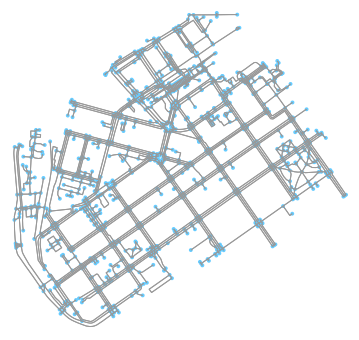

In [2]:
fig, ax = ox.plot_graph(G)

As we can see, now we have fetched walkable streets from Kamppi. In the figure, the lines are streets and all the nodes are represented with light blue color. 

**How does the actual data look like?**

There are a couple of ways to access the edge and node attributes. The easier way is to use an OSMnx function `graph_to_gdfs()` that returns the nodes and edges as GeoDataFrames. The other option to access the data is via the graph itself by looping through nodes and edges as follow:
  - `for node_id, node in G.nodes(data=True)`
  - `for fr, to, edge in G.edges(data=True)`

Often you want to manipulate nodes and edges somehow. Hence, often it is useful to fetch the data into GeoDataFrames:

In [3]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)  # you can flag whether you want to e.g. exclude nodes 

In [4]:
# Check the first rows of the nodes
nodes.head()

,y,x,osmid,highway,ref,geometry
3216400385,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755)
1372233731,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229)
1005744134,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162)
319885318,60.165072,24.925487,319885318,NaN,NaN,POINT (24.92549 60.16507)
3216400394,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766)


In [5]:
# First rows of the edges
edges.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,service,tunnel,access,bridge,junction,ref
0,3216400385,301360890,0,15240373,Kansakoulukuja,residential,30,False,13.177,"LINESTRING (24.93400 60.16755, 24.93393 60.167...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1372233731,298367080,0,86533507,NaN,footway,NaN,False,6.925,"LINESTRING (24.92927 60.16229, 24.92917 60.16225)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1372233731,292859610,0,15103120,NaN,primary_link,30,False,33.874,"LINESTRING (24.92927 60.16229, 24.92930 60.162...",2,NaN,NaN,NaN,NaN,NaN,NaN
3,1372233731,2390968896,0,"[86533504, 23025219]",Hietalahdenkatu,primary,30,False,68.200,"LINESTRING (24.92927 60.16229, 24.92868 60.162...","[3, 2]",NaN,NaN,NaN,NaN,NaN,NaN
4,1372233731,4430643601,0,"[154412960, 86533507]",NaN,footway,NaN,False,12.489,"LINESTRING (24.92927 60.16229, 24.92941 60.162...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see from this edge-table, we have a lot of information. For routing purposes, the most useful attributes are `length` (in meters) and `maxspeed` (for car routing) which we can use to calculate travel times.

## 2. Modify the graph

Let's next modify the data in our graph, so that we can conduct the shortest path search based on travel time. 

In this case, we specify that the **walking speed is a static 4.5 kmph** and **cycling speed is 19 kmph**. We will calculate the cost of travel (time) for each road segment (i.e. edge) into a new column `walk_t` that we can later use as a weight variable in routing (also known as impedance or cost).  

In [6]:
# Calculate the time (in seconds) it takes to walk through road segments
walk_speed = 4.5  # kmph
edges['walk_t'] = (( edges['length'] / (walk_speed*1000) ) * 60 * 60).round(1)

# Do the same for cycling
cycling_speed = 19  # kmph
edges['bike_t'] = (( edges['length'] / (cycling_speed*1000) ) * 60 * 60).round(1)

# Let's check what we got
edges[['length', 'walk_t', 'bike_t']].head()

,length,walk_t,bike_t
0,13.177,10.5,2.5
1,6.925,5.5,1.3
2,33.874,27.1,6.4
3,68.200,54.6,12.9
4,12.489,10.0,2.4


## 3. Build graph

Now as we have calculated the travel time for our edges. We still need to convert our nodes and edges back to a NetworkX graph, so that we can start using it for routing. When using OSM data fetched with OSMnx this can be done easily with function `ox.gdfs_to_graph()`. Notice that this **only works when using OSMnx library**, we will later see in detail how the graphs are built from scratch which enables you to customize them.

- Let's build the graph with OSMnx:

In [7]:
G = ox.gdfs_to_graph(gdf_nodes=nodes, gdf_edges=edges)
type(G)

networkx.classes.multidigraph.MultiDiGraph

Okay, now we have converted our data back into a NetworkX graph. Let's ensure that our new edge attribute really exists:

In [8]:
# Check only the first row from edges
for fr, to, edge in G.edges(data=True):
    print(edge)
    break

{'osmid': 15240373, 'name': 'Kansakoulukuja', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'length': 13.177, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5aa21ff7f0>, 'walk_t': 10.5, 'bike_t': 2.5}


Great, as we can see now we have a new edge attribute in our graph that we can use for routing. 

## 4. Routing with NetworkX

Now we have everything we need to start routing with NetworkX (by walking and cycling). But first, let's again go through some basics about routing.

### Basic logic in routing

Most (if not all) routing algorithms work more or less in a similar manner. The basic steps for finding an optimal route from A to B, is to:
 1. Find the nearest node for origin location \* (+ get info about its node-id and distance between origin and node)
 2. Find the nearest node for destination location \* (+ get info about its node-id and distance between origin and node)
 3. Use a routing algorithm to find the shortest path between A and B
 4. Retrieve edge attributes for the given route(s) and summarize them (can be distance, time, CO2, or whatever)
 
\* in more advanced implementations you might search for the closest edge

This same logic should be applied always when searching for an optimal route between a single origin to a single destination, or when calculating one-to-many -type of routing queries (producing e.g. travel time matrices). 

## Find the optimal route between two locations

Next, we will learn how to find the shortest path between two locations using [Dijkstra's](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) algorithm.

First, let's find the closest nodes for two locations that are located in the area. OSMnx provides a handly function for geocoding an address `ox.geocode()`. We can use that to retrieve the x and y coordinates of our origin and destination.

In [9]:
# OSM data is in WGS84 so typically we need to use lat/lon coordinates when searching for the closest node

# Origin
orig_address = "Kalevankatu 16, Helsinki"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Ruoholahdenkatu 24, Helsinki"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: 24.936245 60.1665678
Destination coords: 24.9246625 60.1641351


Okay, now we have coordinates for our origin and destination.

### Find the nearest nodes

Next, we need to find the closest nodes from the graph for both of our locations. For calculating the closest point we use here `'haversine'` formula to get the distance in meters (with `return_dist=True`).

In [10]:
# 1. Find the closest nodes between origin and destination
orig_node_id, dist_to_orig = ox.get_nearest_node(G, point=(orig_y, orig_x), method='haversine', return_dist=True)
dest_node_id, dist_to_dest = ox.get_nearest_node(G, point=(dest_y, dest_x), method='haversine', return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: 298372995 and distance: 43.872491349361404 meters.
Destination node-id: 5809140035 and distance: 48.867235001413256 meters.


Now we are ready to start the actual routing with NetworkX. 

### Find the fastest route by walking / cycling

Now we can do the routing and find the shortest path between the origin and target locations
by using the `dijkstra_path()` function of NetworkX. For getting only the cumulative cost of the trip, we can directly use a function `dijkstra_path_length()` that returns the travel time without the actual path. 

With `weight` -parameter we can specify the attribute that we want to use as cost/impedance. We have now three possible weight attributes available: `'length'`, `'walk_t'` and `'bike_t'`.    

- Let's first calculate the routes between locations by walking and cycling, and also retrieve the travel times

In [11]:
import networkx as nx
# Calculate the paths by walking and cycling
walk_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='walk_t')
bike_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='bike_t')

# Get also the actual travel times (summarize)
walk_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='walk_t')
bike_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='bike_t')

Okay, that was it! Let's now see what we got as results by visualizing the results.

For visualization purposes, we can use a handy function again from OSMnx called `ox.plot_graph_route()` (for static) or `ox.plot_route_folium()` (for interactive plot).

- Let's first make static maps

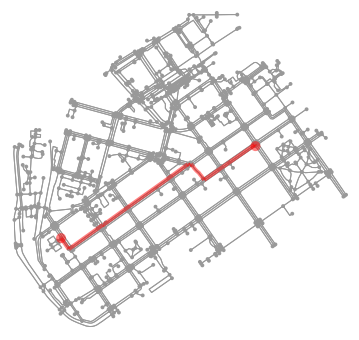

Text(0.5, 0, 'Walk time  12.0 minutes.')

In [12]:
# Walking
fig, ax = ox.plot_graph_route(G, walk_path)

# Add the travel time as title
ax.set_xlabel("Walk time {t: .1f} minutes.".format(t=walk_t/60))

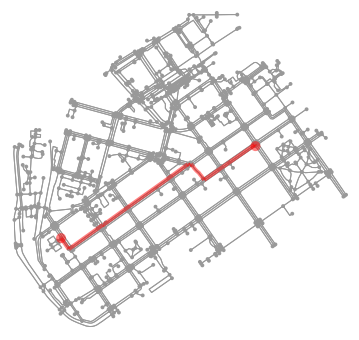

Text(0.5, 0, 'Cycling time  2.8 minutes.')

In [13]:
# Cycling
fig, ax = ox.plot_graph_route(G, bike_path)

# Add the travel time as title
ax.set_xlabel("Cycling time {t: .1f} minutes.".format(t=bike_t/60))

Great! Now we have successfully found the optimal route between our origin and destination and we also have estimates about the travel time that it takes to travel between the locations by walking and cycling. As we can see, the route for both travel modes is exactly the same which is natural, as the only thing that changed here was the constant travel speed.

- Let's still finally see an example how you can plot a nice interactive map out of our results with OSMnx:

In [14]:
ox.plot_route_folium(G, walk_path, popup_attribute='walk_t')

## Calculate travel times from one to many locations

When trying to understand the accessibility of a specific location, you typically want to look at travel times between multiple locations (one-to-many) or use isochrones (travel time contours). 

- Let's see how we can calculate travel times from the origin node, to all other nodes in our graph using NetworkX function `single_source_dijkstra_path_length()`:

In [15]:
# Calculate walk travel times originating from one location
walk_times = nx.single_source_dijkstra_path_length(G, source=orig_node_id)

# What did we get?
#walk_times

As we can see, the result is a dictionary where we have the **node_id** as keys and the **travel time** as values. 

For visualizing this information, we need to join this data with the nodes. For doing this, we can first convert the result to DataFrame and then we can easily merge the information with the nodes GeoDataFrame.

In [16]:
import pandas as pd
# Convert to DataFrame and add column names
walk_times_df = pd.DataFrame([list(walk_times.keys()), list(walk_times.values())]).T
walk_times_df.columns = ['node_id', 'walk_t']

# What do we have now?
walk_times_df.head()

,node_id,walk_t
0,298372995,0
1,298372997,1
2,3227176324,1
3,298372996,1
4,310042886,1


Great! Now we have the travel times **from origin** to all other nodes in the graph. 

- Let's finally merge the data with the nodes GeoDataFrame and visualize the results

In [17]:
# Check the nodes
nodes.head()

,y,x,osmid,highway,ref,geometry
3216400385,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755)
1372233731,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229)
1005744134,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162)
319885318,60.165072,24.925487,319885318,NaN,NaN,POINT (24.92549 60.16507)
3216400394,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766)


As we can see, the `node_id` in the nodes GeoDataFrame can be found from the `index` of the gdf as well as from the column `osmid`. 

- Let's merge these two datasets:

In [18]:
# Merge the datasets
nodes = nodes.merge(walk_times_df, left_on='osmid', right_on='node_id')

# Check
nodes.head()

,y,x,osmid,highway,ref,geometry,node_id,walk_t
0,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755),3216400385,13
1,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229),1372233731,18
2,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162),1005744134,25
3,60.165072,24.925487,319885318,NaN,NaN,POINT (24.92549 60.16507),319885318,24
4,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766),3216400394,11


Okay, now we have also the travel times associated for each node. 

- Let's visualize this:

(60.16, 60.17)

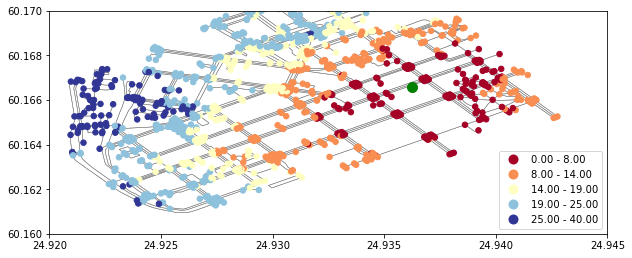

In [21]:
%matplotlib inline

# Make a GeoDataFrame for the origin point so that we can visualize it
orig = gpd.GeoDataFrame({'geometry': [Point(orig_x, orig_y)]}, index=[0], crs={'init': 'epsg:4326'})

# Plot the results with edges and the origin point (green)
ax = edges.plot(lw=0.5, color='gray', zorder=0, figsize=(10,10))
ax = nodes.plot('walk_t', ax=ax, cmap='RdYlBu', scheme='natural_breaks', k=5, markersize=30, legend=True)
ax = orig.plot(ax=ax, markersize=100, color='green')

# Adjust axis 
ax.set_xlim([24.92, 24.945])
ax.set_ylim([60.160, 60.170])

Okay, as we can see now we have quickly calculated the travel times for each node in the graph using a single call.

If you would have for example a predefined grid, you could find the nearest node for each grid centroid to produce a more matrix-like result. 

### Alternative approach - Egograph

Alternatively, it is possible to directly set a specific time limit and restrict **how long the graph is travelled** from the origin, and return that subgraph for the user. 

- Let's see an example:

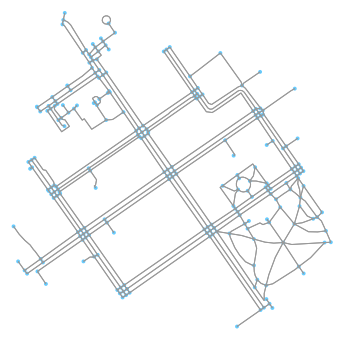

In [20]:
# Take a subgraph until 4 minutes by walking (240 seconds)
subgraph = nx.ego_graph(G, n=orig_node_id, radius=240, distance='walk_t')
fig, ax = ox.plot_graph(subgraph)

As we can see, with this approach we can retrieve a partial graph that we could for example visualize with different colors, or e.g. subset the extent of our accessibility analysis to cover only specific range from the source. 